Accompanied with Stone et al. (2022), how to utilize the package to create temperature profile maps of AGN accretion disks using spectroscopic/photometric light curve data.

First, we will need to import the necessary packages, as well as the package itself. All required packages are located in "requirements.txt"

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numba_progress import ProgressBar
from numba import njit

import astropy.constants as const
import astropy.units as u
from astropy.table import Table
import awkward as ak
from scipy.sparse import csc_matrix

from tqdm import tqdm

In [8]:
import temp_map.utils as utils
import temp_map.algorithm as alg
import temp_map.plotting as tpplot
import temp_map.input as tpin
import temp_map.run as run

These are just parameters to make the plots look nice (to me at least)

In [9]:
import matplotlib as mpl

mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['xtick.top'] = True
mpl.rcParams['xtick.direction'] = 'in'

mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['ytick.direction'] = 'in'

mpl.rcParams["figure.autolayout"] = False

mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams["axes.axisbelow"] = False

Let's use spectra from the RM Catalog described in Shen et al. (2019). These continuum spectral flux densities and sampled wavelengths are all given in the quasar rest frame.

In [10]:
obj_dat = np.load('RMID017_Data.npz')

td_vals = obj_dat['dates']
flux_dat = obj_dat['flux']*1e-17/1e-8
err_dat = obj_dat['error']*1e-17/1e-8
lambda_vals = obj_dat['wavelength']*1e-8 #in cm

Here are the AGN parameters fpr this particular object:

In [11]:
AGN_params = {'obj_name': 'RMID017',
              'MBH': 9.236463689188385e+41,
              'lambda_edd': 0.012427965765322145,
              'z':0.456502,
              'dist':5.458996719914234e+27}

We assume $\alpha = 6$ and $i = 30^o$

In [12]:
AGN_params['alpha'] = 6
AGN_params['inc'] = 30*np.pi/180

Now we redshift correct the times into the quasar rest frame, and only use data from before the first gap in cadence:

In [13]:
diffs = np.diff(td_vals)
good_ind = np.argwhere( diffs > 25 ).T[0]

td_vals = td_vals[ :good_ind[0] ]
flux_dat = flux_dat[ :good_ind[0], : ]
err_dat = err_dat[ :good_ind[0], : ]


td_vals = (td_vals - np.min(td_vals) ) / (1 + AGN_params['z'])


N_td = len(td_vals)
N_nu = len(lambda_vals)

We also need to sample these data points from a gaussian centered on their value with widths corresponding to their uncertainties:

In [14]:
flux_dat = np.random.normal(flux_dat, err_dat)

It's worthwhile to flatten the flux and error arrays:

In [15]:
flux_dat_flat = np.zeros( N_nu*N_td )
err_dat_flat = np.zeros( N_nu*N_td )

for i in range(N_td):
    for j in range(N_nu):
        flux_dat_flat[ N_nu*i + j ] = flux_dat[i,j]
        err_dat_flat[ N_nu*i + j ] = err_dat[i,j]

Now, we have the input spectra with error, but in terms of the absolute flux $F_\lambda$. We need the input to be the flux perturbations $\delta F_\lambda$, so we'll need to subtract the mean spectrum to approximate it. So first, we'll need to generate the mean spectrum.

In [16]:
mean_spec = np.zeros(N_nu)
for i in range(N_td):
    mean_spec += flux_dat_flat[i*N_nu:(i+1)*N_nu]

mean_spec /= N_td

Now we can subtract the mean spectrum from the input spectra with error.

In [17]:
processed_input_spec = np.zeros(N_td*N_nu)
for i in range(N_td):
    processed_input_spec[i*N_nu:(i+1)*N_nu] = flux_dat_flat[i*N_nu:(i+1)*N_nu] - mean_spec

Now that we have the processed input spectra, we need to construct the grids for each parameter used in the inversion. We construct the $t_p$ array to start a few days before the first observation, and end a few days after the last observation.

In [18]:
N_tp = 100
tp_vals, dt = np.linspace(td_vals[0]-2, td_vals[-1]+2, N_tp, retstep=True, dtype=float)

To construct the $u$ array, we need to determine the range of radii probed by the spectroscopic data. This involves both the parameters of the AGN, and the range of $\lambda$ observed in the data. 

Luckily, there is a convenient function in "utils" to show us the range of relevant radii and output the range we need.

100%|██████████| 20/20 [00:00<00:00, 144.67it/s]


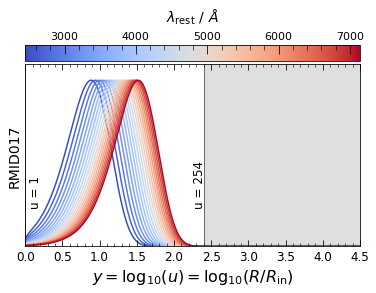

In [19]:
ymin, ymax, ymin2, ymax2 = utils.get_filter_kernels(lambda_vals, AGN_params, plot=True)

This shows the filter kernels (like in NK22) for each wavelength. Of course, this doesn't show the filter kernel for each wavelength, this would take much too long and make the plot much more confusing. Furthermore, the output values are in terms of $y = \log_{10}(u)$, which we'll be working in for the rest of the analysis.

We'll sample the radii evenly in $y$, between $y_{min}$ and $y_{max}$. 

In [20]:
Nu = 50
yvals, dy = np.linspace(ymin, ymax, Nu, retstep=True)

## Using the algorithm

Now that we have the input spectra and temperature map, we can start constructing the $W_\sigma$ matrix for the inversion. There is a function in "algorithm" that can construct this matrix for us, with a number of options (many similar to the function to construct $F_\lambda$).

The $W_\sigma$ matrix will lilely be very large ($N_\nu N_{t_d}$ x $N_u N_{t_p}$), so we will use a SciPy sparse CSC matrix to construct it. This requires an array for the column, row, and value of each nonzero element in the matrix.

However, there is a caveat: this is a numba function, which is very particular about what classes and functions can be used within it. For example, numba functions do not like python lists to be appended. So, we will need to use an Awkward array to construct the CSC sparse matrix arrays. These arrays are then used as inputs to the function, filled, and then output.

After we have these Awkward arrays, we need to turn them into arrays that can be accessed by other functions, so we get a "snapshot" of each of them. There is then a function (chunk_fill) to chunk-in the CSC matrix, which tracks how much of the matrix has been filled with a progress bar. It fills in the matrix in chunks of data, one chunk at a time (which is specified in one of the arguments).

This chunk filling function also requires the shape of the array, which would normally be $N_\nu N_{t_d}$ x $N_u N_{t_p}$. However, we include an additional parameter per wavelength to account for the difference in the model steady-state and the mean input spectrum. So, we use a shape of $N_\nu N_{t_d}$ x ($N_u N_{t_p} + N_\nu$).

In [21]:
row_dat = ak.ArrayBuilder()
col_dat = ak.ArrayBuilder()
input_dat = ak.ArrayBuilder()

with ProgressBar(total=Nu*N_tp*N_nu*N_td) as progress:
    rows, cols, inputs = alg.make_W_spec_w_mean(row_dat, col_dat, input_dat, 
                                                yvals, tp_vals, td_vals, 
                                                lambda_vals,
                                                AGN_params['lambda_edd'], 
                                                AGN_params['MBH'], 
                                                AGN_params['dist'], 
                                                AGN_params['inc'], 
                                                alpha=AGN_params['alpha'], 
                                                progress_hook=progress,
                                                errs=err_dat_flat, 
                                                dat_type='dToT')

row_snap = rows.snapshot()
col_snap = cols.snapshot()
dat_snap = inputs.snapshot()

W_matrix = utils.chunk_fill(row_snap, col_snap, dat_snap, shape=( N_nu*N_td, Nu*N_tp + N_nu ), Nchunk=int(1e6))

  8%|▊         | 56147840.0/720440000 [00:11<02:18, 4808976.11it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

100%|██████████| 56/56 [00:27<00:00,  2.05it/s]


Now that we have $W_\sigma$, we can construct the other relevant matrices for the inversion: $W_\sigma^T W_\sigma$, $I$, $D_k$, $D_l$.

It should be noted: we are working in terms of $\delta T / T$, **NOT** $\delta T$ (this was an option in the construction of the $W_\sigma$ matrix with "dat_type").

In NK22, they use $I_T$, $D_{kT}$, and $D_{lT}$, which are matrices divided by the steady-state temperature profile $T_0$. We include $T_0$ in the map we solve for, so we don't need to include it in all of these smoothing matrices and $W_\sigma$. This can be changed in the formation of $W_\sigma$.

There are functions to form the smoothing matrices, but only if we are working in terms of $\delta T / T$. This requires the size (of one side) of $W_\sigma^T W_\sigma$ and the size of the $u$ and $t_p$ arrays. To get these matrices when working in terms of $\delta T$, you would have to manually divide elements by the temperature as described in NK22.

In [22]:
WTW = W_matrix.transpose().dot( W_matrix )
size = WTW.shape[0]

I, Dk, Dl = alg.make_smoothing_matrices(Nu, N_tp, size)

We can now construct the right hand side of the equation: $W_\sigma^T \delta F_\sigma$

In [23]:
RHS = W_matrix.transpose() @ (processed_input_spec/err_dat_flat)
RHS = csc_matrix(RHS).transpose()

Next, we use the inversion formula specified in the paper:
$\delta T = [W_\sigma^T W_\sigma + \xi(I + D_k + D_l)] W_\sigma^T \delta F_\sigma$

To do this, we need to choose smoothing factors $\xi$ to use. I'll pick the usual values: 1, 10, 100, 1000.
I've also made a function that parallelizes the inversion with numba - this isn't needed but speeds upt the process. Each smoothing factor will have an output temperature profile map, which I'll put into an array **inv_outputs**.

In [24]:
@njit(parallel=True)
def fast_res(A, b):
    return np.linalg.inv(A) @ b

xi_vals = [1,10,100,1000]

inv_outputs = []
for xi in tqdm(xi_vals):
    A = csc_matrix( WTW + xi*(I + Dk + Dl) )

    res = fast_res(A.todense(), RHS.todense())
    res = np.array(res).T[0]

    inv_outputs.append( res )

100%|██████████| 4/4 [00:19<00:00,  4.78s/it]


## Constructing and plotting the output

We have the output maps now, but they are in their flattened form, so we need to reshape them to be a 2D array like we had before. We'll place all of the reshaped arrays in an array labeled **dToT_outputs_reshape**.

In [25]:
dToT_outputs_reshape = []

for n in range(len(inv_outputs)):
    dToT_output_reshape = np.zeros((Nu, N_tp))
    for i in range(Nu*N_tp):
        dToT_output_reshape[ i%Nu, i//Nu ] = inv_outputs[n][i]
        
    dToT_outputs_reshape.append(dToT_output_reshape)

We can't plot the results yet because we need the $\chi^2$ values to display on the plot. To get these values, we'll need to construct the output spectra from the output temperature maps to compare to the input spectra. 

We can do this using the simple formula from the paper:
$\delta F_\sigma = W_\sigma \cdot \delta T$

We can also get the extra parameters used in the inversion as additive offsets between the model and data mean spectrum, one per wavelength. It should be noted that this gives us the output spectra **relative to the error** $\delta F_\sigma$, so we need to multiply by the error of the input spectra.

In [26]:
new_spec = []
for i in range(len(inv_outputs)):
    out = np.array( (W_matrix @ inv_outputs[i]) )
    new_spec.append( out * err_dat_flat )

offsets = []
for i in range(len(inv_outputs)):
    offsets.append( inv_outputs[i][Nu*N_tp:]  )

It's easier to manipulate the data (and plot it) if we reshape the input and output data.

In [27]:
new_spec_stacked = np.zeros( (len(xi_vals), N_nu, N_td) )
flux_dat_stacked = np.zeros( (N_nu, N_td) )
err_dat_stacked = np.zeros( (N_nu, N_td) )

for i in range(len(new_spec)):
    for j in range(N_td):
        ind1 = j*N_nu
        ind2 = (j+1)*N_nu

        new_spec_stacked[i,:,j] = new_spec[i][ind1:ind2]

for j in range(N_td):
    ind1 = j*N_nu
    ind2 = (j+1)*N_nu

    flux_dat_stacked[:,j] = processed_input_spec[ind1:ind2]
    err_dat_stacked[:,j] = err_dat_flat[ind1:ind2]

Next, we need to normalize the output light curves so they match the input light curves. Each light curve (i.e. wavelength) has an offset fitted by the algorithm, but still needs a multiplicative factor to normalize it to the input light curve. We can obtain this factor by minimizing $\chi^2$ and using the fitted offsets.


Let $\delta F_{in}(\lambda, t_d) = m(\xi, \lambda) \delta F_{out}(\xi, \lambda, t_d) + {\rm offsets} (\xi, \lambda)$

Minimizing $\chi^2$:  
$S_{xy} = \sum \frac{\delta F_{in}   \delta F_{out}}{\sigma^2}$  
$S_{x2} = \sum \frac{\delta F_{out} }{\sigma^2}$  
$S_x = \sum \frac{\delta F_{out}}{\sigma^2}$  
  
$m(\xi, \lambda) = \frac{S_{xy} - {\rm offsets}(\xi, \lambda) S_x }{S_{x2}}$


In [28]:
#Values are very small, so we use a fluff factor
FLUFF = 1e9 

m_coefs = np.zeros( ( len(xi_vals), N_nu ) )

for i in range(len(xi_vals)):
    for j in range(N_nu):
        lc_in = flux_dat_stacked[j,:]*FLUFF
        lc_err = err_dat_stacked[j,:]*FLUFF
        lc_out = new_spec_stacked[i,j,:]

        sxy = np.sum(lc_out*lc_in / lc_err**2)
        sx2 = np.sum(lc_out**2 / lc_err**2)
        sx = np.sum(lc_out / lc_err**2)

        m_coefs[i,j] = (sxy - offsets[i][j]*sx)/sx2 

Now that we have the multiplicative factors $m(\xi, \lambda)$, we can normalize the output spectra, and get the $\chi^2$ per data point ($\chi^2_\nu$) for each temperature map.

In [29]:
fitted_spec = np.zeros( ( len(xi_vals), N_nu, N_td )  )

chi2_tot = []
for i in range(len(xi_vals)):
    chi2_tot.append([])

for a in tqdm( range(N_td) ):
    ind1 = a*N_nu
    ind2 = (a+1)*N_nu


    spec_in = flux_dat_stacked[:,a]
    spec_err = err_dat_stacked[:,a]

    for i in range(len(xi_vals)):
        spec_out = m_coefs[i,:]* new_spec_stacked[i,:,a] + offsets[i]

        fitted_spec[i,:,a] = spec_out/FLUFF
        
        chi2 = np.sum( (spec_in - spec_out/FLUFF)**2 / spec_err**2  )/N_nu
        chi2_tot[i].append(chi2)

chi2_tot = np.mean(chi2_tot, axis=1)        

100%|██████████| 31/31 [00:00<00:00, 1986.00it/s]


Now that we have $\chi^2_\nu$, we can plot the output temperature maps. There is a function to output the temperature maps and the input temperature map. Each temperature map will have a scale it is divided by, which is by default the 99 $^{th}$ percentile of the absolute value of the map, but this number can be changed.

This function takes multiple optional arguments:
- **fname**: the name of the file to save the plot to. If **None**, the plot will not be saved.
- **show**: whether to show the plot. If **False**, the plot will not be shown and the figure will be an output of the function.
- **interpolation**: the interpolation method to use when plotting the temperature maps.
- **percent**: the percentile of the absolute value of the data in the map to use as the scale.
- **date_type**: can either be **rest** or **obs** depending on the frame of the time values used

4it [00:00, 308.78it/s]


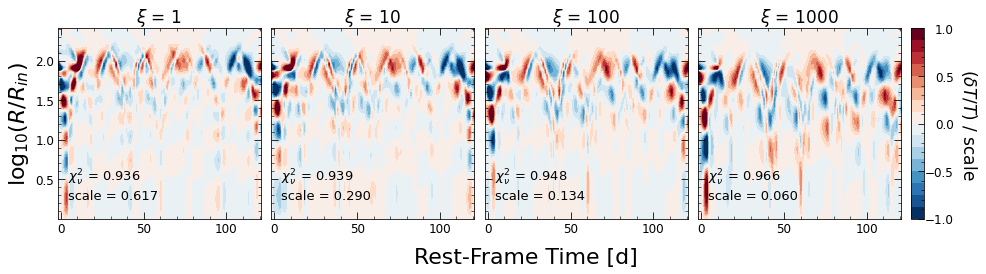

In [30]:
tpplot.plot_profs_out(dToT_outputs_reshape, tp_vals, 
                              yvals, xi_vals, chi2_tot,
                              fname=None, show=True, cmap_num=16, interval=50,
                              interpolation='gaussian', date_type='rest')

We can also plot the output spectra against the input spectra (for each $\xi$) for each time $t_d$ in an animation, and save the animation to a file.

MovieWriter ffmpeg unavailable; using Pillow instead.


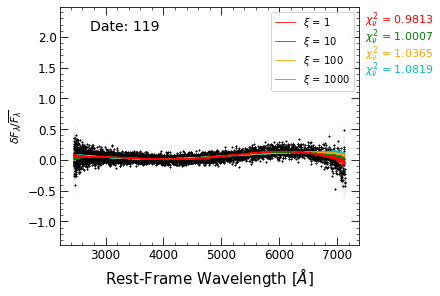

In [33]:
spec_fname = 'OutputSpectra.gif'
tpplot.animate_spectra_out(fitted_spec, flux_dat_stacked, err_dat_stacked, 
                           mean_spec, td_vals, lambda_vals, 
                           xi_vals, spec_fname, fps=5)

We can also save all data to a numpy file for later use. And that's all!

To make this as easy as possible, there is also a function in the module that will run the entire algorithm for you:

Making W matrix...
  8%|▊         | 56147840.0/720440000 [00:07<01:27, 7578267.44it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Inverting...


100%|██████████| 4/4 [00:17<00:00,  4.42s/it]
4it [00:00, 311.09it/s]


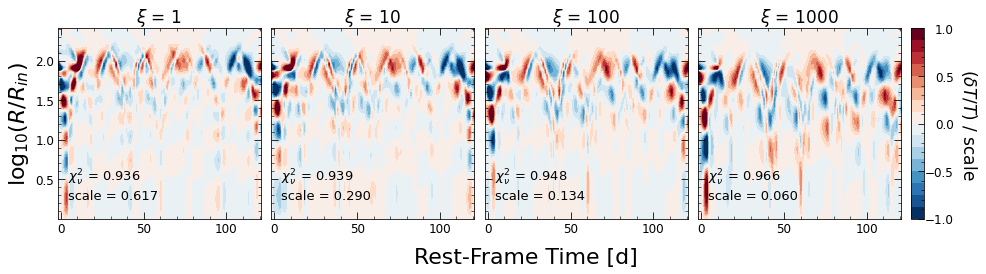

In [50]:
output = run.run_spectra(processed_input_spec, err_dat_flat, mean_spec, 
                         tp_vals, yvals, td_vals, lambda_vals, 
                         AGN_params, xi_vals=[1,10,100,1000], 
                         show_tp=True, tp_fname=None, spec_fname=None, dat_fname=None)